# 
# (2023/10/17) Trainerクラスを利用した特定ボンドの学習用コード
# 

こちらはxyzから直接計算するコード．

In [1]:
import numpy as np

In [2]:
# 
# * itpデータの読み込み
# note :: itpファイルは記述子からデータを読み込む場合は不要なのでコメントアウトしておく
itpdir="ethanol.acpype/input_GMX.itp"
import ml.atomtype
# 実際の読み込み
itp_data=ml.atomtype.read_itp(itpdir)
bonds_list=itp_data.bonds_list
NUM_MOL_ATOMS=itp_data.num_atoms_per_mol
atomic_type=itp_data.atomic_type


 -----  ml.read_itp  :: parse results... -------
 bonds_list ::  [[0, 1], [0, 3], [0, 4], [0, 5], [1, 2], [1, 6], [1, 7], [2, 8]]
 counter    ::  9
 atomic_type::  ['c3', 'c3', 'oh', 'hc', 'hc', 'hc', 'h1', 'h1', 'ho']
 atom_list  ::  ['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H']
 -----------------------------------------------
 CH bonds...       [[0, 3], [0, 4], [0, 5], [1, 6], [1, 7]]
 CO bonds...       [[1, 2]]
 OH bonds...       [[2, 8]]
 OO bonds...       []
 CC bonds...       [[0, 1]]
 CC ring bonds...  []
 

 ring_bond_index  []
 ch_bond_index    [1, 2, 3, 5, 6]
 oh_bond_index    [7]
 co_bond_index    [4]
 cc_bond_index    [0]
 O atoms (lonepair)...       [2]
 N atoms (lonepair)...       []


In [3]:
#
#* logging levelの設定
#* Trainerクラス内ではloggingを使って出力しているので必須

import logging
import sys

def set_up_script_logger(logfile: str, verbose: str = "INFO"):
    # Configure the root logger so stuff gets printed
    root_logger = logging.getLogger()
    root_logger.setLevel(logging.INFO) # CRITICAL
    root_logger.handlers = [
        logging.StreamHandler(sys.stderr),
        logging.StreamHandler(sys.stdout),
    ]
    level = getattr(logging, verbose.upper())
    root_logger.handlers[0].setLevel(level)
    root_logger.handlers[1].setLevel(logging.INFO) #CRITICAL
    if logfile is not None:
        root_logger.addHandler(logging.FileHandler(logfile, mode="w"))
        root_logger.handlers[-1].setLevel(level)
    return root_logger

# INFO以上のlogを出力
set_up_script_logger("atoms_wan", verbose="INFO")

<RootLogger root (INFO)>

In [4]:
#
# * モデルのロード（NET_withoutBNは従来通りのモデル）
# !! モデルは何を使っても良いが，インスタンス変数として
# !! self.modelname
# !! だけは絶対に指定しないといけない．chやohなどを区別するためにTrainerクラスでこの変数を利用している
import ml.mlmodel 
import importlib
importlib.reload(ml.mlmodel)

# *  モデル（NeuralNetworkクラス）のインスタンス化
model_ch = ml.mlmodel.NET_withoutBN("ch",288, 20, 6)

from torchinfo import summary
summary(model=model_ch)

#from torchinfo import summary
#summary(model=model_ring)

 model NET :: nfeatures ::  288
nfeatures_enet :: 72 
nfeatures_fnet :: 120 


Layer (type:depth-idx)                   Param #
NET_withoutBN                            --
├─Linear: 1-1                            3,650
├─Linear: 1-2                            2,550
├─Linear: 1-3                            73,440
├─Linear: 1-4                            6,050
├─Linear: 1-5                            2,550
├─Linear: 1-6                            1,020
Total params: 89,260
Trainable params: 89,260
Non-trainable params: 0

In [6]:
#
# * xyzをロード
import ase
import ase.io
# !! edit here !! 
xyzfilename="/Volumes/Realtek RTL9210B-CG Media_2/15_ethanol/32mol/traj/IONS+CENTERS_cell_1.xyz"
atoms_list = ase.io.read(xyzfilename,index=":")


In [81]:
#
# * xyzからatoms_wanクラスを作成する．
# note :: datasetから分離している理由は，wannierの割り当てを並列計算でやりたいため．
import importlib
import cpmd.class_atoms_wan 
importlib.reload(cpmd.class_atoms_wan)

atoms_wan_list = []

for atoms in atoms_list:
    atoms_wan_list.append(cpmd.class_atoms_wan.atoms_wan(atoms,NUM_MOL_ATOMS,itp_data))


In [84]:
# 
# * まずwannierの割り当てを行う．
# TODO :: joblibでの並列化を試したが失敗した．
# TODO :: どうもjoblibだとインスタンス変数への代入はうまくいかないっぽい．
for atoms_wan_fr in atoms_wan_list:
    y = lambda x:x._calc_wcs()
    y(atoms_wan_fr)

In [65]:
# #
# # * atoms_wanの割り当ては並列計算で実施したかったが，以下のコードは動かなかった
# import joblib
# # result_ase = joblib.Parallel(n_jobs=-1, verbose=50)(joblib.delayed(atoms_wan_fr._calc_wcs()) for atoms_wan_fr in atoms_wan_list)
# from joblib import Parallel, delayed 
# # runs = [A(x) for x in range(20)]
# with Parallel(n_jobs=6, verbose=5) as parallel:
#     y = lambda x:x._calc_wcs() # maybe need to define OUTSIDE parallel
#     run_A = parallel([delayed(y)(atoms_wan_fr) for atoms_wan_fr in atoms_wan_list])
#     # run_A = parallel([delayed(lambda x:x._calc_wcs())(atoms_wan_fr) for atoms_wan_fr in atoms_wan_list]) # this does not work...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 126 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 486 tasks      | elapsed:    4.5s
[Parallel(n_jobs=6)]: Done 990 tasks      | elapsed:    8.7s
[Parallel(n_jobs=6)]: Done 1638 tasks      | elapsed:   14.2s
[Parallel(n_jobs=6)]: Done 2000 out of 2000 | elapsed:   17.2s finished


In [191]:
#
# * データセットの作成およびデータローダの設定

import importlib
import ml.ml_dataset 
importlib.reload(ml.ml_dataset)

# make dataset
# 第二変数で訓練したいボンドのインデックスを指定する．
# 第三変数は記述子のタイプを表す
dataset_ch = ml.ml_dataset.DataSet_xyz(atoms_wan_list, itp_data.bond_index['CH_1_bond'],"allinone")


In [192]:
# #
# # * CHボンドの記述子と双極子をload

# import numpy as np
# descs_X_ch = np.loadtxt(descsdir+'Descs_ch.csv',delimiter=',')
# data_y_ch = np.loadtxt(descsdir+'True_y_ch.csv',delimiter=',')
# # 記述子の形は，(フレーム数*ボンド数，記述子の次元数)となっている．これが前提なので注意
# print("shape descs_X_ch :: {}".format(np.shape(descs_X_ch)))
# print("shape data_y_ch :: {}".format(np.shape(data_y_ch)))
# print("Finish reading desc and true_y")
# print("max descs_X_ch :: ", np.max(descs_X_ch))


In [193]:
# #
# # * データセットの作成およびデータローダの設定

# import importlib
# import ml.ml_dataset 
# importlib.reload(ml.ml_dataset)

# # make dataset
# dataset_ch = ml.ml_dataset.DataSet_custom(descs_X_ch,data_y_ch)


In [202]:
#
# * 訓練用クラスのimport
import ml.ml_train
import importlib
importlib.reload(ml.ml_train)

# 
# TODO :: schedulerの実装がまだできておらず，learning rateは固定値しか受け付けない．
Train = ml.ml_train.Trainer(
    model_ch,  # モデルの指定
    device = "cpu",   # Torchのdevice
    batch_size = 1,  # 訓練のバッチサイズ（xyzのframe数に対応しているので注意）
    validation_batch_size = 1, # validationのバッチサイズ（xyzのframe数に対応しているので注意）
    max_epochs    = 1,
    learning_rate = 1e-2, # starting learning rate
    n_train = 1000, # データ数（xyzのフレーム数のこと）
    n_val   = 100,  # データ数（xyzのフレーム数のこと）
    modeldir = "chmodel_test")


model data will be saved to chmodel_test


model data will be saved to chmodel_test


Torch device (cpu or cuda gpu or m1 mac gpu): cpu


Layer (type:depth-idx)                   Param #
NET_withoutBN                            --
├─Linear: 1-1                            3,650
├─Linear: 1-2                            2,550
├─Linear: 1-3                            73,440
├─Linear: 1-4                            6,050
├─Linear: 1-5                            2,550
├─Linear: 1-6                            1,020
Total params: 89,260
Trainable params: 89,260
Non-trainable params: 0
Torch device (cpu or cuda gpu or m1 mac gpu): cpu


In [203]:
#
# * データをtrain/validで分割
# note :: 分割数はn_trainとn_valでTrainer引数として指定
Train.set_dataset(dataset_ch)

 n_traing ( number of training  data): 1000


 n_traing ( number of training  data): 1000


 n_val    ( number of validatin data): 100


 n_val    ( number of validatin data): 100


In [204]:
Train.train()

epoch= 1 : time= 369.98033118247986 [s] : loss(train)= 1.747090943325311 : loss(valid)= 0.007154891714453698 : RMSE[D](train)= 0.157089562564022 : RMSE[D](valid)= 0.08454679348454665


epoch= 1 : time= 369.98033118247986 [s] : loss(train)= 1.747090943325311 : loss(valid)= 0.007154891714453698 : RMSE[D](train)= 0.157089562564022 : RMSE[D](valid)= 0.08454679348454665
 model is saved to model_ch_weight.pth at chmodel_test
 model is saved to model_ch_all.pth at chmodel_test
 model is saved to model_ch.pt at chmodel_test


0

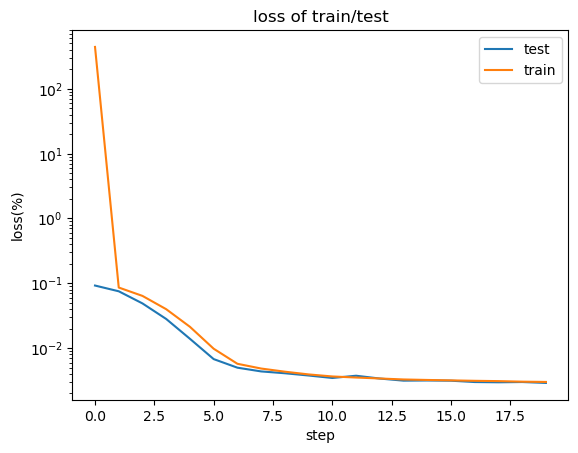

In [165]:
#
# * lossをグラフ化する: epochごとに平均化されたloss（log scale）

import importlib
import ml.ml_train
import ml.ml_plot
importlib.reload(ml.ml_train)
importlib.reload(ml.ml_plot)
ml.ml_plot.plot_loss_log(Train.epoch_valid_loss,Train.epoch_train_loss)

# 

device (cpu or gpu ?) ::  mps
device (cpu or gpu ?) ::  mps
 RSME_train = 0.05402055382728577
 RSME_valid = 0.05390516296029091


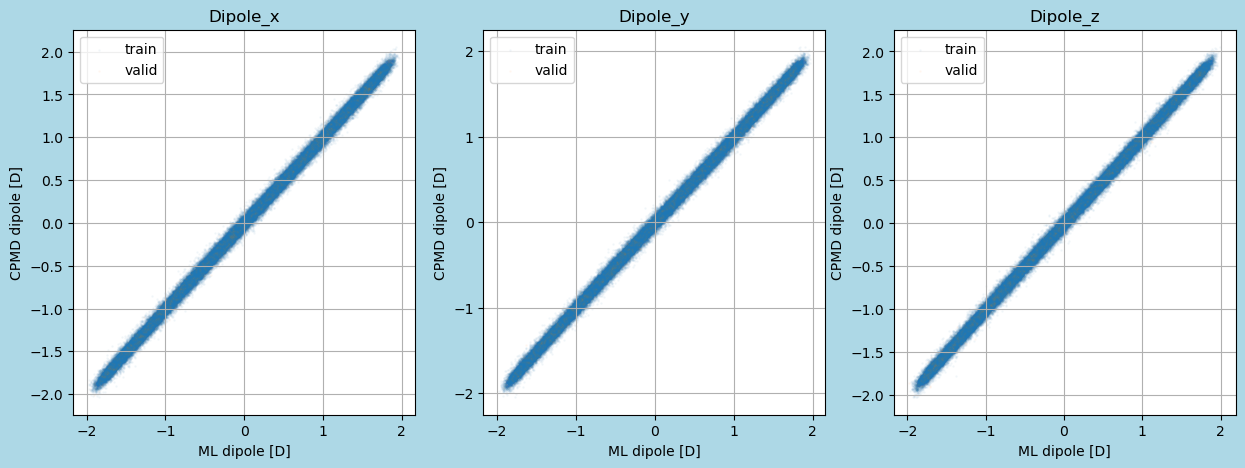

0

In [166]:

import importlib
import ml.ml_train
import ml.ml_plot
importlib.reload(ml.ml_train)
importlib.reload(ml.ml_plot)

ml.ml_plot.plot_residure_train_valid(model_ch, Train.dataset_train, Train.dataset_valid,limit=True)


In [141]:
# import importlib
# import ml.ml_train
# import ml.ml_plot
# importlib.reload(ml.ml_train)
# importlib.reload(ml.ml_plot)
# ml.ml_plot.plot_residure_density(model_ch, dataset_ch)

device (cpu or gpu ?) ::  mps
device (cpu or gpu ?) ::  mps
 RSME_train = 0.05678088963031769
 RSME_valid = 0.056091632694005966


0

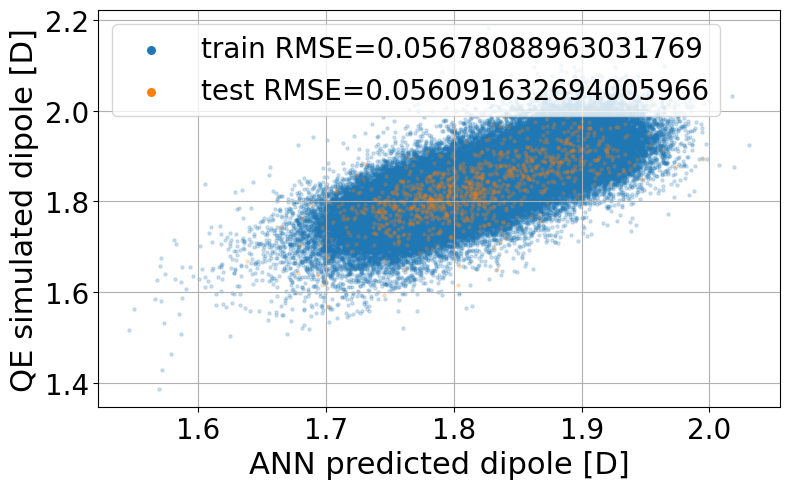

In [149]:
import importlib
import ml.ml_train
import ml.ml_plot
importlib.reload(ml.ml_train)
importlib.reload(ml.ml_plot)
ml.ml_plot.plot_norm(model_ch, Train.dataset_train,Train.dataset_valid)

In [110]:
# 
# * データ保存
# もしもデータを保存したい場合は以下をコメントアウトして実行する

# # [size,3]の形でdipoleを返す
# from ml.ml_train import calculate_final_dipoles
# test_pred_list, test_true_list = calculate_final_dipoles(model_ch, Train.dataset_valid)
# train_pred_list, train_true_list = calculate_final_dipoles(model_ch, Train.dataset_train)

# np.save("ch_valid_pred.npy",test_pred_list)
# np.save("ch_valid_true.npy",test_true_list)
# np.save("ch_train_pred.npy",train_pred_list)
# np.save("ch_train_true.npy",train_true_list)



device (cpu or gpu ?) ::  mps
device (cpu or gpu ?) ::  mps
